<a href="https://colab.research.google.com/github/AstridFigueroaa/Deep-Learning/blob/main/notebooks/Proyecto_Deteccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.   Setup



In [1]:
!pip install -q kaggle


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.1 MB/s eta 0:00:00


In [27]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import os
import random
import pandas as pd
from PIL import Image
import cv2
from ultralytics import YOLO
from IPython.display import Video
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import pathlib
import glob
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# 2.   Datos



In [10]:
#Obtención del dataset de Kaggle
!kaggle datasets download pkdarabi/cardetection


Dataset URL: https://www.kaggle.com/datasets/pkdarabi/cardetection
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/99.8M [00:00<?, ?B/s]
100% 99.8M/99.8M [00:00<00:00, 1.12GB/s]


In [11]:
#Desomprimiendo el archivo zip obtenido de Kaggle
!unzip cardetection.zip -d /content/

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/car/train/labels/00000_00003_00024_png.rf.08957035e670072dbb22d8f9905e9b84.txt  
  inflating: /content/car/train/labels/00000_00003_00025_png.rf.11e558fae394d310693ee9223b8962ca.txt  
  inflating: /content/car/train/labels/00000_00003_00026_png.rf.1f6b33373353f896f2c2025ffd264e51.txt  
  inflating: /content/car/train/labels/00000_00003_00026_png.rf.a3b6c2dcd4ee9a8064667b7bb266590b.txt  
  inflating: /content/car/train/labels/00000_00003_00027_png.rf.c1381ed46ee0d7e21877ea3d7ef86127.txt  
  inflating: /content/car/train/labels/00000_00003_00029_png.rf.8e24d2606537779612888c6a06c7043d.txt  
  inflating: /content/car/train/labels/00000_00004_00000_png.rf.45dccdbf08ed12f25d7742d8bf88c102.txt  
  inflating: /content/car/train/labels/00000_00004_00001_png.rf.557d3494b3e633e29069a6f42918334e.txt  
  inflating: /content/car/train/labels/00000_00004_00002_png.rf.3e3e95e1ba16cac885d3de7864a40fb4.txt  
  inflating:

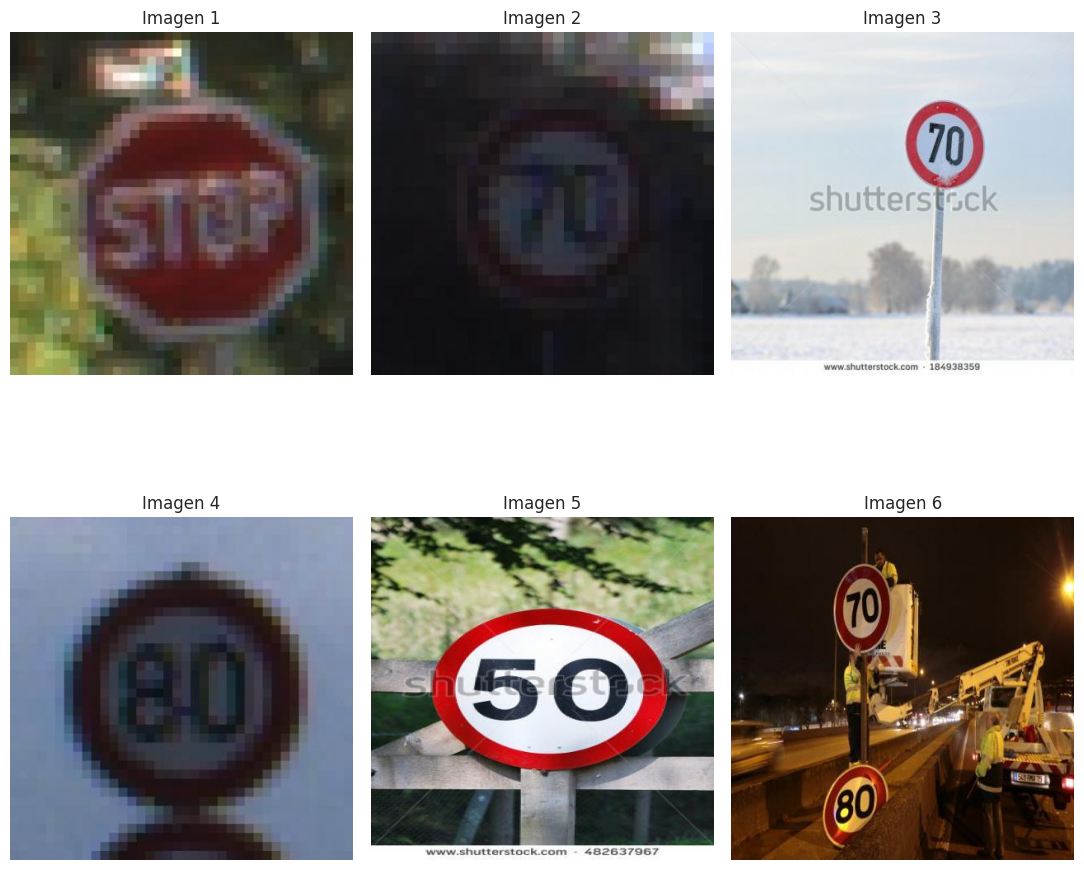

In [16]:
#Conociendo el dataset de entrenamiento
dir = '/content/car/train/images'
#Seleccionaremos 6 imagenes
ejemplos = 6
image_files = os.listdir(dir)
# Selección aleatoria de las 6 imágenes
rand_images = random.sample(image_files, ejemplos)
#Ploteo de las imágenes
fig, axes = plt.subplots(2, 3, figsize=(11, 11))
for i in range(ejemplos):
    image = rand_images[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(dir, image)))
    ax.set_title(f'Imagen {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [21]:
#Tamaño y características de las imágenes
#Selección de imagen aleatoria
image = cv2.imread("/content/car/train/images/000008_jpg.rf.bd6ae6db0f8c0eb727706bc322ce21ae.jpg")
#Obtención de las características
h, w, c = image.shape
#Print de características
print("Altura: ", h)
print("Ancho: ", w)
print("Canales: ", c)

Altura:  416
Ancho:  416
Canales:  3


In [29]:
# Conociendo la información sobre el dataset
import os
import yaml
from collections import Counter
from PIL import Image

# Ruta base del dataset
base_path = '/content/car'

# Ruta del archivo data.yaml
yaml_path = os.path.join(base_path, '/content/car/data.yaml')

# Leer nombres de clases desde data.yaml
if os.path.exists(yaml_path):
    with open(yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)
        class_names = data_yaml.get('names', [])
        dataset_source = data_yaml.get('path', base_path)


# Particiones
splits = ['train', 'test', 'valid']
dataset_info = {}
#Recopilación de la información
for split in splits:
    split_path = os.path.join(base_path, split)
    images_path = os.path.join(split_path, 'images')
    labels_path = os.path.join(split_path, 'labels')
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    num_images = len(image_files)

    label_files = [f for f in os.listdir(labels_path) if f.endswith('.txt')]
    class_counter = Counter()

    for label_file in label_files:
        with open(os.path.join(labels_path, label_file), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts:
                    class_id = int(parts[0])
                    class_counter[class_id] += 1

    sample_image = os.path.join(images_path, image_files[0]) if image_files else None
    resolution = None
    if sample_image:
         with Image.open(sample_image) as img:
            resolution = img.size
    dataset_info[split] = {
        'num_images': num_images,
        'class_distribution': dict(class_counter),
        'sample_resolution': resolution
    }

# Mostrar resultados
print(f"\n Fuente del dataset: {dataset_source}")
print(f" Clases detectadas:")
for class_id, name in enumerate(class_names):
    print(f"  ID {class_id}: {name}")
print("===============================================================================================")
for split, info in dataset_info.items():
    print(f"\n Partición: {split}")
    print(f" Número de imágenes: {info['num_images']}")
    print(f" Resolución de ejemplo: {info['sample_resolution']}")
    print(" Distribución de clases:")
    for class_id, count in info['class_distribution'].items():
        class_name = class_names[class_id] if class_id < len(class_names) else f"Clase {class_id}"
        print(f"  - {class_name} (ID {class_id}): {count} ocurrencias")
    print("===============================================================================================")



 Fuente del dataset: /content/car
 Clases detectadas:
  ID 0: Green Light
  ID 1: Red Light
  ID 2: Speed Limit 10
  ID 3: Speed Limit 100
  ID 4: Speed Limit 110
  ID 5: Speed Limit 120
  ID 6: Speed Limit 20
  ID 7: Speed Limit 30
  ID 8: Speed Limit 40
  ID 9: Speed Limit 50
  ID 10: Speed Limit 60
  ID 11: Speed Limit 70
  ID 12: Speed Limit 80
  ID 13: Speed Limit 90
  ID 14: Stop

 Partición: train
 Número de imágenes: 3530
 Resolución de ejemplo: (416, 416)
 Distribución de clases:
  - Stop (ID 14): 285 ocurrencias
  - Speed Limit 30 (ID 7): 334 ocurrencias
  - Speed Limit 100 (ID 3): 267 ocurrencias
  - Speed Limit 80 (ID 12): 323 ocurrencias
  - Speed Limit 90 (ID 13): 168 ocurrencias
  - Speed Limit 120 (ID 5): 252 ocurrencias
  - Speed Limit 70 (ID 11): 318 ocurrencias
  - Speed Limit 60 (ID 10): 301 ocurrencias
  - Speed Limit 40 (ID 8): 235 ocurrencias
  - Speed Limit 110 (ID 4): 101 ocurrencias
  - Speed Limit 20 (ID 6): 285 ocurrencias
  - Red Light (ID 1): 585 ocurrenc

In [32]:
import csv
# Guardar resultados en CSV
csv_path = '/content/drive/MyDrive/YOLOv8_analisis/resumen_dataset.csv'
with open(csv_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['Partición', 'Num_Imagenes', 'Resolución', 'Clase', 'ID_Clase', 'Ocurrencias'])

    for split, info in dataset_info.items():
        for class_id, count in info['class_distribution'].items():
            class_name = class_names[class_id] if class_id < len(class_names) else f"Clase {class_id}"
            writer.writerow([
                split,
                info['num_images'],
                f"{info['sample_resolution'][0]}x{info['sample_resolution'][1]}" if info['sample_resolution'] else "N/A",
                class_name,
                class_id,
                count
            ])

print(f"\n Archivo CSV guardado en: {csv_path}")




✅ Archivo CSV guardado en: /content/drive/MyDrive/YOLOv8_analisis/resumen_dataset.csv


In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Ruta al archivo CSV creado con la información para hacer gráficas
csv_path = '/content/drive/MyDrive/YOLOv8_analisis/resumen_dataset.csv'
#Ruta donde se guardarán las gráficas creadas
output_dir = '/content/drive/MyDrive/YOLOv8_analisis'
# Leer el archivo creado con la información
df = pd.read_csv(csv_path)

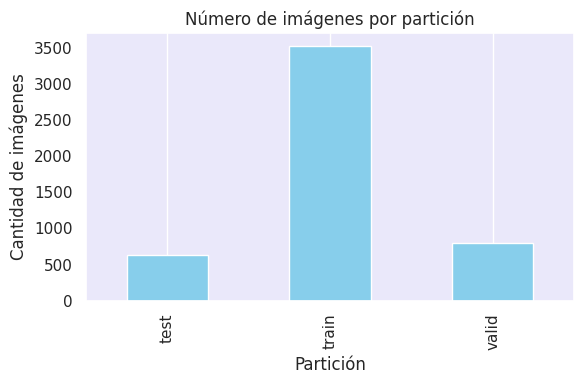

In [46]:
# 1. Número de imágenes por partición
image_counts = df.groupby('Partición')['Num_Imagenes'].max()

plt.figure(figsize=(6,4))
image_counts.plot(kind='bar', color='skyblue')
plt.title('Número de imágenes por partición')
plt.ylabel('Cantidad de imágenes')
plt.xlabel('Partición')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'nro_imágenes_por_partición.jpg'))
plt.show()
plt.close()

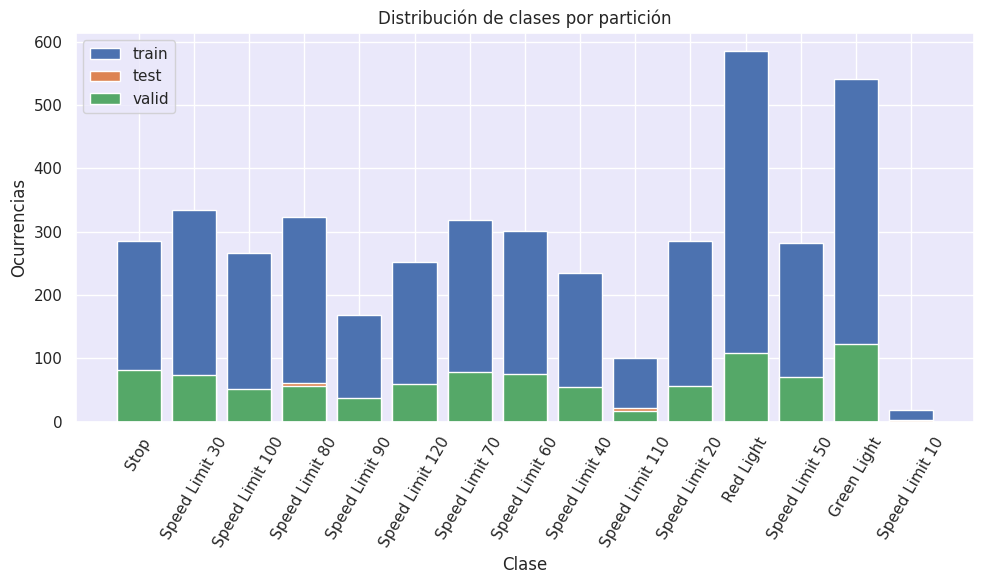

In [47]:
# 2. Distribución de clases por partición
plt.figure(figsize=(10,6))
for split in df['Partición'].unique():
    subset = df[df['Partición'] == split]
    plt.bar(subset['Clase'], subset['Ocurrencias'], label=split)

plt.title('Distribución de clases por partición')
plt.ylabel('Ocurrencias')
plt.xlabel('Clase')
plt.xticks(rotation=60)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'clases_por_particion.jpg'))
plt.show()
plt.close()



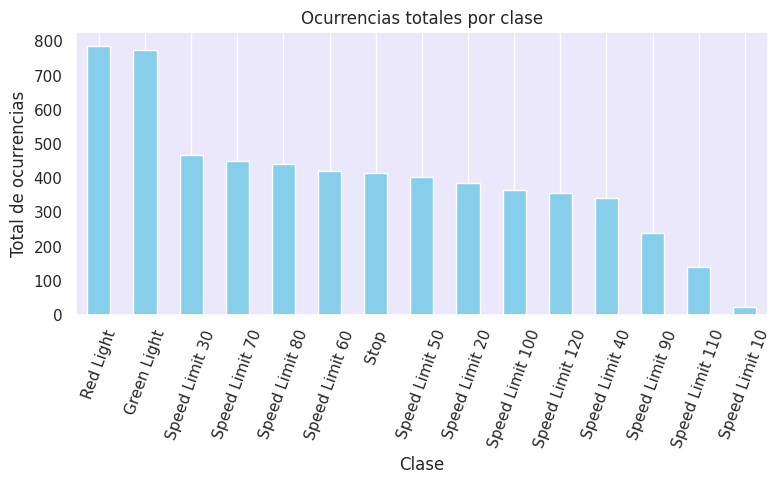

In [48]:
# 3. Ocurrencias totales por clase
total_class_counts = df.groupby('Clase')['Ocurrencias'].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
total_class_counts.plot(kind='bar', color='skyblue')
plt.title('Ocurrencias totales por clase')
plt.ylabel('Total de ocurrencias')
plt.xlabel('Clase')
plt.xticks(rotation=70)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'grafico_ocurrencias_totales.jpg'))
plt.show()
plt.close()


# 3. Preprocesamiento

In [52]:
import os
import shutil

# Rutas base para las particiones
data_dir = "/content/car"
train_img_dir = os.path.join(data_dir, "train/images")
train_lbl_dir = os.path.join(data_dir, "train/labels")
val_img_dir = os.path.join(data_dir, "valid/images")
val_lbl_dir = os.path.join(data_dir, "valid/labels")
test_img_dir = os.path.join(data_dir, "test/images")
test_lbl_dir = os.path.join(data_dir, "test/labels")

# Verificamos que las carpetas existan y contengan imágenes y etiquetas
def check_files(img_dir, lbl_dir):
    img_files = os.listdir(img_dir)
    lbl_files = os.listdir(lbl_dir)
    print(f"Imágenes encontradas en {img_dir}: {len(img_files)}")
    print(f"Etiquetas encontradas en {lbl_dir}: {len(lbl_files)}")

check_files(train_img_dir, train_lbl_dir)
check_files(val_img_dir, val_lbl_dir)
check_files(test_img_dir, test_lbl_dir)

# Aseguramos que para cada imagen exista su etiqueta correspondiente
def verify_labels(img_dir, lbl_dir):
    images = set([os.path.splitext(f)[0] for f in os.listdir(img_dir)])
    labels = set([os.path.splitext(f)[0] for f in os.listdir(lbl_dir)])
    missing_lbl = images - labels
    if missing_lbl:
        print(f"Faltan etiquetas para las imágenes: {missing_lbl}")
    else:
        print("Todas las imágenes tienen su etiqueta correspondiente.")

print("Verificando etiquetas en train:")
verify_labels(train_img_dir, train_lbl_dir)
print("Verificando etiquetas en valid:")
verify_labels(val_img_dir, val_lbl_dir)
print("Verificando etiquetas en test:")
verify_labels(test_img_dir, test_lbl_dir)



Imágenes encontradas en /content/car/train/images: 3530
Etiquetas encontradas en /content/car/train/labels: 3530
Imágenes encontradas en /content/car/valid/images: 801
Etiquetas encontradas en /content/car/valid/labels: 801
Imágenes encontradas en /content/car/test/images: 638
Etiquetas encontradas en /content/car/test/labels: 638
Verificando etiquetas en train:
Todas las imágenes tienen su etiqueta correspondiente.
Verificando etiquetas en valid:
Todas las imágenes tienen su etiqueta correspondiente.
Verificando etiquetas en test:
Todas las imágenes tienen su etiqueta correspondiente.


Es importante mencionar que el archivo yaml ya existe, por lo que no es necesario crear uno, anteriormente hemos verificado las clases definidas en este archivo.

# 4. Entrenamiento A/B/C

In [53]:
#Definiendo los directorios de datos para entrenamiento
data_dir = "/content/car"

train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

In [ ]:
# Función para entrenar los modelos YOLO
def train_yolo(model_name, epochs=10):
    print(f"Entrenando modelo {model_name}...")
    model = YOLO(model_name)
    yaml = "/content/car/data.yaml"
    results = model.train(data = yaml, epochs=epochs)
    return results, model

# Entrenando los tres modelos
results_n, model_n = train_yolo("yolov8n.pt")
results_s, model_s = train_yolo("yolov8s.pt")
results_m, model_m = train_yolo("yolov8m.pt")

Entrenando modelo yolov8n.pt...
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/car/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True

# 5. Evaluación (test / eval)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Función para extraer métricas clave del objeto metrics.resultados_dict
def extract_metrics(metrics):
    results = metrics.metrics
    return {
        "Accuracy": results.get("metrics/accuracy", None),
        "Precision": results.get("metrics/precision(B)", None),
        "Recall": results.get("metrics/recall(B)", None),
        "F1": results.get("metrics/f1score(B)", None),
    }

# Evaluar modelos usando modelo.val() y el archivo yaml (usa el set de validación o test definido ahí)
metrics_n = model_n.val(data="/content/car/data.yaml")
metrics_s = model_s.val(data="/content/car/data.yaml")
metrics_m = model_m.val(data="/content/car/data.yaml")

# Extraer métricas en diccionario
met_n = extract_metrics(metrics_n)
met_s = extract_metrics(metrics_s)
met_m = extract_metrics(metrics_m)

# Crear dataframe para graficar comparativo
df_metrics = pd.DataFrame([met_n, met_s, met_m], index=["YOLOv8n", "YOLOv8s", "YOLOv8m"])

print("Métricas comparativas:")
print(df_metrics)

# Graficar las métricas
plt.figure(figsize=(10,6))
for model in df_metrics.index:
    plt.plot(df_metrics.columns, df_metrics.loc[model], marker='o', label=model)
plt.title('Comparación de métricas de modelos YOLOv8')
plt.ylim(0,1)
plt.ylabel('Valor')
plt.grid(True)
plt.legend()
plt.show()


# 6. Inferencia de ejemplo

# 7. Guardado de resultados